In [1]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchsparse
import laspy

from EHydro_TreeUnet.tree_unet import UNet
from pathlib import Path
from typing import Literal, Tuple

from torch import nn
from torch.cuda import amp
from torchsparse import SparseTensor
from torchsparse.nn import functional as F
from torch.utils.data import random_split, DataLoader
from torchsparse.utils.collate import sparse_collate_fn
from torchsparse.utils.quantize import sparse_quantize

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
TRAINING = True

TRAIN_PCT = 0.9
VOXEL_SIZE = 0.1
DATA_AUGMENTATION_COEF = 2.0
SEMANTIC_LOSS_COEF = 1.0
PARENT_LOSS_COEF = 2.0

In [3]:
class FORinstanceDataset:
    def __init__(self, voxel_size: float, data_augmentation: float = 1.0, bound_connectivity: Literal[6, 26] = 6, yaw_range = (0, 360), tilt_range = (-5, 5), scale = (0.9, 1.1)) -> None:
        self._rng = np.random.default_rng()
        self._folder = Path('./datasets/FORinstance')
        self._extensions = ('.laz', '.las')
        
        self._files = sorted(
            [f for f in self._folder.rglob("*") if f.is_file() and f.suffix.lower() in self._extensions],
            key=lambda f: f.name
        )

        self._voxel_size = voxel_size
        self._len = int(len(self._files) * data_augmentation)

        if bound_connectivity == 6:
            self._neigh = np.array([[+1,0,0],[-1,0,0],[0,+1,0],[0,-1,0],[0,0,+1],[0,0,-1]], dtype=np.int32)
        elif bound_connectivity == 26:
            self._neigh = np.array([[dx,dy,dz]
                            for dx in (-1,0,1)
                            for dy in (-1,0,1)
                            for dz in (-1,0,1)
                            if not (dx==dy==dz==0)], dtype=np.int32)
        else:
            raise ValueError("Boundary connectivity must be 6 or 26")
        
        self._yaw_range = yaw_range
        self._tilt_range = tilt_range
        self._scale = scale
        
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return [self._load_file(self.files[i]) for i in range(*idx.indices(len(self)))]
        elif isinstance(idx, int):
            if idx < 0:
                idx += len(self)
            if idx < 0 or idx >= len(self):
                raise IndexError("Index out of range")
            return self._preprocess(idx)
        else:
            raise TypeError("Index must be a slice or an integer")
        
    def __len__(self):
        return self._len
    
    def _load_file(self, path):
        ext = path.suffix.lower()

        coords = ...
        feats = ...
        semantic_labels = ...
        instance_labels = ...
        
        if ext in ('.las, .laz'):
            file = laspy.read(path)

            coords = np.vstack((file.x, file.y, file.z)).transpose()
            coords -= np.min(coords, axis=0, keepdims=True)
            feats = np.vstack((file.intensity, file.return_number, file.number_of_returns)).transpose()
            semantic_labels = np.array(file.classification)
            instance_labels = np.array(file.treeID)
        else:
            raise ValueError(f'Unsopported file extension: {ext}!')

        return coords, feats, semantic_labels, instance_labels
    
    def _agument_data(self, coords):
        yaw = np.deg2rad(self._rng.uniform(*self._yaw_range))
        pitch = np.deg2rad(self._rng.uniform(*self._tilt_range))
        roll = np.deg2rad(self._rng.uniform(*self._tilt_range))
        scale = self._rng.uniform(*self._scale)

        cy, sy = np.cos(yaw), np.sin(yaw)
        cp, sp = np.cos(pitch), np.sin(pitch)
        cr, sr = np.cos(roll), np.sin(roll)

        rotation_mtx = np.array([[cy*cp,  cy*sp*sr - sy*cr,  cy*sp*cr + sy*sr],
                                 [sy*cp,  sy*sp*sr + cy*cr,  sy*sp*cr - cy*sr],
                                 [ -sp ,            cp*sr ,            cp*cr ]],
                                dtype=coords.dtype)

        return (coords @ rotation_mtx.T) * scale

    def _pack_keys(self, coords: np.ndarray, mins: Tuple[int, int, int], mult_y: int, mult_z: int) -> np.ndarray:
        x, y, z = coords[:, 0] - mins[0], coords[:, 1] - mins[1], coords[:, 2] - mins[2]
        return x * mult_y * mult_z + y * mult_z + z

    def _get_boundary_mask(self, coords: np.ndarray, instance_labels: np.ndarray) -> np.ndarray:
        coords = coords.astype(np.int64, copy=False)
        mins = coords.min(0)
        maxs = coords.max(0)
        mult_y = (maxs[1] - mins[1] + 1)
        mult_z = (maxs[2] - mins[2] + 1)

        keys = self._pack_keys(coords, mins, mult_y, mult_z)
        order = np.argsort(keys)
        keys_sorted = keys[order]
        ids_sorted  = instance_labels[order]

        N = len(coords)
        boundary = np.zeros(N, dtype=bool)

        for d in self._neigh:
            neigh_keys = self._pack_keys(coords + d, mins, mult_y, mult_z)
            idx = np.searchsorted(keys_sorted, neigh_keys, side='left')

            in_range = idx < N
            idx_ok   = idx[in_range]
            neigh_eq = keys_sorted[idx_ok] == neigh_keys[in_range]

            has_neighbor = np.zeros(N, dtype=bool)
            has_neighbor[in_range] = neigh_eq

            neighbor_ids = np.empty(N, dtype=instance_labels.dtype)
            neighbor_ids.fill(-1)
            neighbor_ids[in_range] = ids_sorted[idx_ok]

            boundary |= has_neighbor & (neighbor_ids != instance_labels)

        return boundary
        
    def _preprocess(self, idx: int):
        coords, feat, semantic_labels, instance_labels = self._load_file(self._files[idx % len(self._files)])
        if idx >= len(self._files):
            coords = self._agument_data(coords)

        mask = semantic_labels != 3

        coords = coords[mask]
        feat = feat[mask]
        semantic_labels = semantic_labels[mask]
        semantic_labels = np.where(semantic_labels > 3, semantic_labels - 1, semantic_labels)
        instance_labels = instance_labels[mask]
            
        coords, indices = sparse_quantize(coords, self._voxel_size, return_index=True)
        feat = feat[indices]
        semantic_labels = semantic_labels[indices]
        instance_labels = instance_labels[indices]
        boundary_labels = self._get_boundary_mask(coords, instance_labels)

        coords = torch.tensor(coords, dtype=torch.int)
        feat = torch.tensor(feat.astype(np.float32), dtype=torch.float)
        semantic_labels = torch.tensor(semantic_labels, dtype=torch.long)
        boundary_labels = torch.tensor(boundary_labels, dtype=torch.long)

        inputs = SparseTensor(coords=coords, feats=feat)
        semantic_labels = SparseTensor(coords=coords, feats=semantic_labels)
        boundary_labels = SparseTensor(coords=coords, feats=boundary_labels)

        return {"inputs": inputs, "semantic_labels": semantic_labels, "boundary_labels": boundary_labels}

In [4]:
class TreeUNetTester:
    def __init__(self):
        conv_config = F.conv_config.get_default_conv_config(conv_mode=F.get_conv_mode())
        conv_config.kmap_mode = 'hashmap'
        F.conv_config.set_global_conv_config(conv_config)

        self._model = UNet(3, 6)
        self._device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        dataset = FORinstanceDataset(voxel_size=VOXEL_SIZE, data_augmentation=DATA_AUGMENTATION_COEF)
        train_size = int(TRAIN_PCT * len(dataset))
        val_size = len(dataset) - train_size
        
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        self._train_loader = DataLoader(train_dataset, batch_size=1, collate_fn=sparse_collate_fn)
        self._val_loader = DataLoader(val_dataset, batch_size=1, collate_fn=sparse_collate_fn)

        self._criterion_semantic = nn.CrossEntropyLoss()
        self._criterion_contour = nn.CrossEntropyLoss()

        if not TRAINING:
            self._load_weights()

        self._model.to(self._device)

    def _load_weights(self):
        self._model.load_state_dict(torch.load('./weights/tree_unet_weights.pth'))

    def _compute_loss(self, semantic_output, semantic_labels, boundary_output, boundary_labels):
        loss_sem = self._criterion_semantic(semantic_output, semantic_labels)
        loss_cont = self._criterion_contour(boundary_output, boundary_labels)

        return SEMANTIC_LOSS_COEF * loss_sem + PARENT_LOSS_COEF * loss_cont
    
    def train(self):
        optimizer = torch.optim.Adam(self._model.parameters(), lr=1e-3)
        scaler = amp.GradScaler(enabled=True)
        losses = []

        for k, feed_dict in enumerate(self._train_loader):
            inputs = feed_dict["inputs"].to(self._device)
            semantic_labels = feed_dict["semantic_labels"].to(self._device)
            boundary_labels = feed_dict["boundary_labels"].to(self._device)

            with amp.autocast(enabled=True):
                semantic_output, boundary_output = self._model(inputs)
                loss = self._compute_loss(semantic_output.F, semantic_labels.F, boundary_output.F, boundary_labels.F)

            print(f"[step {k + 1}] loss = {loss.item()}")
            losses.append(loss.item())

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        torch.save(self._model.state_dict(), './weights/tree_unet_weights.pth')

        plt.figure(figsize=(10, 5))
        plt.plot(losses, label="Training Loss")
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.title("Evolución del Loss durante el entrenamiento")
        plt.legend()
        plt.grid(True)
        plt.show()

    def eval(self):
        self._model.eval()
        losses = []

        # enable torchsparse 2.0 inference
        # enable fused and locality-aware memory access optimization
        torchsparse.backends.benchmark = True  # type: ignore

        with torch.no_grad():
            for k, feed_dict in enumerate(self._val_loader):
                semantic_labels_cpu = feed_dict["semantic_labels"].F.numpy()
                boundary_labels_cpu = feed_dict["boundary_labels"].F.numpy()

                inputs = feed_dict["inputs"].to(self._device)
                semantic_labels = feed_dict["semantic_labels"].to(self._device)
                boundary_labels = feed_dict["boundary_labels"].to(self._device)

                with amp.autocast(enabled=True):
                    semantic_output, boundary_output = self._model(inputs)
                    loss = self._compute_loss(semantic_output.F, semantic_labels.F, boundary_output.F, boundary_labels.F)

                print(f"[inference step {k + 1}] loss = {loss.item()}")
                losses.append(loss.item())

                coords = semantic_output.C[:, 1:].cpu().numpy()
                semantic_output = torch.argmax(semantic_output.F.cpu(), dim=1).numpy()
                boundary_output = torch.argmax(boundary_output.F.cpu(), dim=1).numpy()

                yield coords, semantic_output, semantic_labels_cpu, boundary_output, boundary_labels_cpu

        plt.figure(figsize=(10, 5))
        plt.plot(losses, label="Training Loss")
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.title("Evolución del Loss durante la evaluación")
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f'Loss medio: {sum(losses) / len(losses)}')

[step 1] loss = 3.242095947265625
[step 2] loss = 3.143908977508545
[step 3] loss = 2.8327386379241943
[step 4] loss = 2.4886958599090576
[step 5] loss = 2.24914813041687
[step 6] loss = 2.0532991886138916
[step 7] loss = 2.0157322883605957
[step 8] loss = 1.930383563041687
[step 9] loss = 1.787947177886963
[step 10] loss = 1.791166067123413
[step 11] loss = 1.6649686098098755
[step 12] loss = 1.656897783279419
[step 13] loss = 1.5628416538238525
[step 14] loss = 1.5258816480636597
[step 15] loss = 1.5597155094146729
[step 16] loss = 1.996311902999878
[step 17] loss = 1.3729839324951172
[step 18] loss = 1.3388962745666504
[step 19] loss = 1.3813040256500244
[step 20] loss = 1.5328056812286377
[step 21] loss = 1.3099045753479004
[step 22] loss = 1.2320456504821777
[step 23] loss = 1.1571640968322754
[step 24] loss = 1.1898417472839355
[step 25] loss = 1.1881182193756104
[step 26] loss = 1.2399715185165405
[step 27] loss = 1.3183047771453857
[step 28] loss = 1.195809006690979
[step 29] l

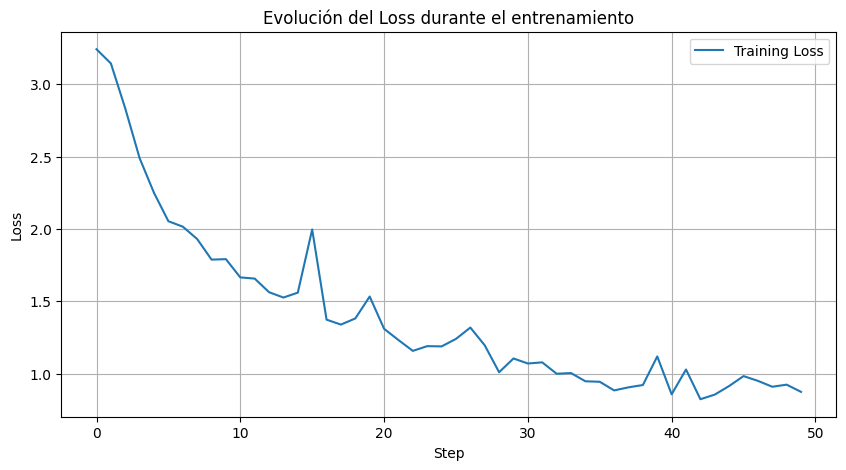

[inference step 1] loss = 0.8451560735702515
[Open3D INFO]   -- Mouse view control --
[Open3D INFO]     Left button + drag         : Rotate.
[Open3D INFO]     Ctrl + left button + drag  : Translate.
[Open3D INFO]     Wheel button + drag        : Translate.
[Open3D INFO]     Shift + left button + drag : Roll.
[Open3D INFO]     Wheel                      : Zoom in/out.
[Open3D INFO] 
[Open3D INFO]   -- Keyboard view control --
[Open3D INFO]     [/]          : Increase/decrease field of view.
[Open3D INFO]     R            : Reset view point.
[Open3D INFO]     Ctrl/Cmd + C : Copy current view status into the clipboard.
[Open3D INFO]     Ctrl/Cmd + V : Paste view status from clipboard.
[Open3D INFO] 
[Open3D INFO]   -- General control --
[Open3D INFO]     Q, Esc       : Exit window.
[Open3D INFO]     H            : Print help message.
[Open3D INFO]     P, PrtScn    : Take a screen capture.
[Open3D INFO]     D            : Take a depth capture.
[Open3D INFO]     O            : Take a captur

KeyboardInterrupt: 

In [5]:
tester = TreeUNetTester()

if TRAINING:
    tester.train()

pcd = o3d.geometry.PointCloud()
for coords, semantic_output, semantic_labels, boundary_output, boundary_labels in tester.eval():
    colors = np.full((coords.shape[0], 3), 0.8, dtype=np.float32)
    colors[boundary_labels == 1] = [1.0, 0.0, 0.0]
    pcd.points = o3d.utility.Vector3dVector(coords)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd])

    colors = np.full((coords.shape[0], 3), 0.8, dtype=np.float32)
    colors[boundary_output == 1] = [1.0, 0.0, 0.0]
    pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd])